# 中文文本分类

本次作业采用了THUCNews新闻文本分类数据集,使用了其中的6个分类,分别为体育、娱乐、家居、房产、教育、时尚,每个分类5000条,总共30000条新闻数据。数据集的格式为每行一个样本,每个样本包含一个标签和一段文本,标签和文本之间用制表符分隔。

In [8]:
import pandas as pd
import jieba
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

## 数据预处理

导入数据

In [5]:
import pandas as pd
data=pd.read_csv('cnews.train.txt',sep='\t',names=['label','content'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    30000 non-null  object
 1   content  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


In [6]:
data.head()

,label,content
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...


分层划分数据集

In [10]:
# 分层划分数据集
train_data, temp_data = train_test_split(
    data, 
    test_size=6000/len(data),  
    stratify=data['label'],
    random_state=42
)

test_data, val_data = train_test_split(
    temp_data,
    test_size=0.5, 
    stratify=temp_data['label'],
    random_state=42
)
print(f"\n训练集大小：{len(train_data)}")
print(f"测试集大小：{len(test_data)}")
print(f"验证集大小：{len(val_data)}")


训练集大小：24000
测试集大小：3000
验证集大小：3000


## 文本处理

加载停用词表

In [ ]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f])

def chinese_preprocess(text):
    words = jieba.lcut(text)
    return ' '.join([word for word in words if word not in stopwords and len(word) > 1])

# 应用停用词
train_data['processed'] = train_data['content'].apply(chinese_preprocess)
test_data['processed'] = test_data['content'].apply(chinese_preprocess)
val_data['processed'] = val_data['content'].apply(chinese_preprocess)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\95888\AppData\Local\Temp\jieba.cache
Loading model cost 0.515 seconds.
Prefix dict has been built successfully.


# 特征工程

TF-IDF向量化

In [15]:
tfidf = TfidfVectorizer(
    max_features=5000,  # 限制特征数量
    ngram_range=(1, 2)  # 包含一元和二元语法
)

# 训练集拟合
X_train = tfidf.fit_transform(train_data['processed'])
# 转换其他数据集
X_test = tfidf.transform(test_data['processed'])
X_val = tfidf.transform(val_data['processed'])

标签编码

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(train_data['label'])
y_test = le.transform(test_data['label'])
y_val = le.transform(val_data['label'])

## SVM训练

In [ ]:
svm = SVC(
    kernel='linear', 
    C=0.8,            # 通过验证集调整后的参数
    class_weight='balanced', 
    random_state=42,
    verbose=True
)
svm.fit(X_train, y_train)



[LibSVM]

SVC(C=0.8, class_weight='balanced', kernel='linear', random_state=42,
    verbose=True)

## 模型评估

In [23]:
y_pred = svm.predict(X_test)

print("\n分类报告：")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=le.classes_,
    digits=4
))

# 计算F1分数
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
print(f"\n宏平均 F1: {macro_f1:.4f}")
print(f"微平均 F1: {micro_f1:.4f}")



分类报告：
              precision    recall  f1-score   support

          体育     0.9980    1.0000    0.9990       500
          娱乐     0.9861    0.9940    0.9900       500
          家居     0.9722    0.9800    0.9761       500
          房产     0.9861    0.9900    0.9880       500
          教育     0.9839    0.9800    0.9820       500
          时尚     0.9857    0.9680    0.9768       500

    accuracy                         0.9853      3000
   macro avg     0.9853    0.9853    0.9853      3000
weighted avg     0.9853    0.9853    0.9853      3000


宏平均 F1: 0.9853
微平均 F1: 0.9853


recision (精确率)：表示在所有被模型预测为某一类别的样本中，真正属于该类别的比例。

recall (召回率)：表示在所有实际属于某一类别的样本中，被正确识别出来的比例。

f1-score (F1分数)：是精确率和召回率的调和平均数，用来综合衡量一个分类器的效果。F1分数同时考虑了假正例和假反例的影响，值越高越好。

support (支持度)：指用于评估每个类别的实例数量。这里每种类别都有500个测试样本。


accuracy (准确率)：整个模型对所有类别的总体预测准确性。在这个例子中，准确率为0.9853，意味着大约98.53%的预测是正确的。

macro avg (宏平均)：计算各个类别指标（如精确率、召回率、F1分数）的算术平均值，不考虑各类别之间的样本不平衡问题。这里的宏平均显示每个指标都是0.9853。

weighted avg (加权平均)：与宏平均类似，但根据每个类别的支持度（即样本量大小）进行加权后计算得出。由于本例中每个类别的样本数量相同，所以加权平均的结果与宏平均一致，也是0.9853。

宏平均 F1: 所有类别的F1分数的简单平均值，在此案例中为0.9853。

微平均 F1: 先将真阳性、假阳性等统计信息汇总起来再计算出的F1分数，在这种情况下也等于0.9853。


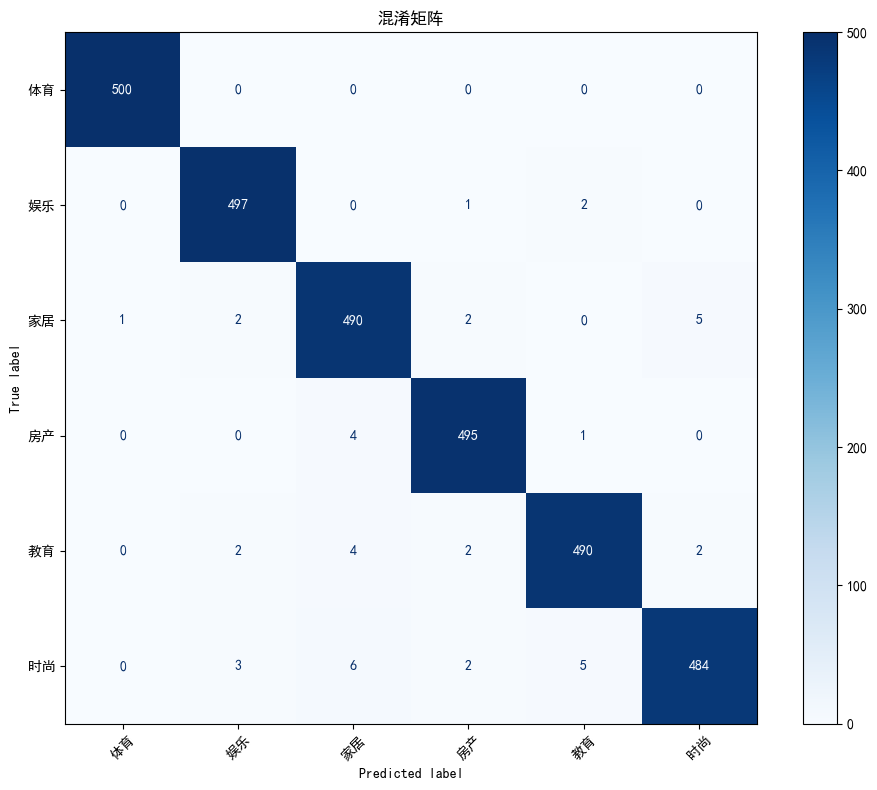

In [ ]:
# 混淆矩阵
plt.figure(figsize=(10, 8))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)
disp.plot(
    include_values=True,
    cmap='Blues',
    ax=plt.gca(),
    xticks_rotation=45
)
plt.title('混淆矩阵')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

由图可看出,对角线颜色都很深，分类效果较好。